# Movie lens data engineering

This notebook presents more sophisticated feature engineering for the movie lens data. 

Due to the nature of the data set being rich in movie attributes (with no user attributes as well as context of interaction), most feature engineering therefore will be carried out on movies.

## Dataset download

In [2]:
import os
from tqdm import tqdm
from nvtabular.utils import download_file

MOVIE_LENS_DATA_PATH = './data/ml-25m/'

if not os.path.isdir(MOVIE_LENS_DATA_PATH):
    download_file(
        "http://files.grouplens.org/datasets/movielens/ml-25m.zip", os.path.join(MOVIE_LENS_DATA_PATH, "ml-25m.zip")
    )
!ls $MOVIE_LENS_DATA_PATH

NVTab_preprocessing  links.csv	 movies_features.csv	     test.csv
README.txt	     ml-25m	 movies_preprocessed_v4.csv  train.csv
genome-scores.csv    ml-25m.zip  ratings.csv
genome-tags.csv      movies.csv  tags.csv


In [3]:
import pandas as pd
import numpy as np

In [4]:
movies = pd.read_csv(MOVIE_LENS_DATA_PATH+"movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = pd.read_csv(MOVIE_LENS_DATA_PATH+"ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [6]:
links = pd.read_csv(MOVIE_LENS_DATA_PATH+"links.csv", dtype={'imdbId':str, 'tmdbId': str})
links.head()

,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


In [7]:
numeric_features = []
cat_features = []

## Feature engineering for movies

### Movies rating statistics

We extract the average rating & numbers of ratings.

In [8]:
movies_num_ratings = pd.DataFrame(ratings.groupby('movieId').agg({'userId': ['count'],
                                                                  'rating': ['mean']}))

In [9]:
movies_num_ratings.columns = ["_".join(x) for x in movies_num_ratings.columns.ravel()]

In [10]:
movies_num_ratings.head()

,userId_count,rating_mean
movieId,,
1,57309,3.893708
2,24228,3.251527
3,11804,3.142028
4,2523,2.853547
5,11714,3.058434


In [11]:
movies = movies.join(movies_num_ratings, on = 'movieId')

In [12]:
movies.head()

,movieId,title,genres,userId_count,rating_mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434


In [13]:
numeric_features += ['userId_count', 'rating_mean']

### Extract movie production year

In [14]:
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)

movies['year_cat'] = movies['year']

In [15]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0


In [16]:
numeric_features += ['year']
cat_features += ['year_cat'] # encode year as both numeric and cat?

### Movies genres
We use one hot encoding for the movie genre.

In [17]:
genre_split = movies['genres'].str.split('|', n=10, expand=True)
genre_split.head()

,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,Adventure,Children,Fantasy,None,None,None,None,None,None,None
2,Comedy,Romance,None,None,None,None,None,None,None,None
3,Comedy,Drama,Romance,None,None,None,None,None,None,None
4,Comedy,None,None,None,None,None,None,None,None,None


In [18]:
genres = set()
for i in range(10):
    movies[i] = genre_split[i]
    genres = genres.union(set(genre_split[i].unique()))

In [19]:
genres.discard(None)
genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [20]:
for genre in genres:
    movies[genre] = 0
    for i in range(10):
        movies[genre] = movies[genre] + (movies[i]==genre)

In [21]:
for i in range(10):
    movies.drop(i, axis=1, inplace=True)
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Romance,Western,...,Children,Mystery,Drama,War,Musical,Animation,Film-Noir,(no genres listed),Documentary,Thriller
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
len(genres)

20

In [23]:
#cat_features += ['genres']

### Content features

We use TF-IDF and SVD to turn text features (title, tag and genres) into numeric feature. 

In [24]:
tags = pd.read_csv(MOVIE_LENS_DATA_PATH+"tags.csv")

# create a mixed dataframe of movies title, genres and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Romance,Western,...,War,Musical,Animation,Film-Noir,(no genres listed),Documentary,Thriller,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,0,0,1,0,0,0,0,791.0,Owned,1.515175e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,0,0,1,0,0,0,0,1048.0,imdb top 250,1.172144e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,0,0,1,0,0,0,0,1361.0,Pixar,1.216146e+09


In [25]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                             lambda x: "%s" % ' '.join(x)))


In [26]:
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x.split('|')))

In [27]:
movies_meta = pd.merge(movies, mixed, on='movieId', how='left')
movies_meta['metadata'] = movies_meta[['genres', 'tag']].apply(
                             lambda x: ' '.join(x), axis = 1)
movies_meta[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy Ow...
1,2,Jumanji (1995),Adventure Children Fantasy Robin Williams time...
2,3,Grumpier Old Men (1995),Comedy Romance funny best friend duringcredits...


#### TF-IDF vectorizer
Next step is to turn the text metadata into a matrix.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_meta['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies_meta['movieId'].tolist())
print(tfidf_df.shape)

(62423, 35768)


In [29]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,35758,35759,35760,35761,35762,35763,35764,35765,35766,35767
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
len(tfidf.vocabulary_)

35768

In [31]:
!mkdir ./assets

mkdir: cannot create directory ‘./assets’: File exists


We save the TF-IDF object for subsequent transform of new movies.

In [32]:
import pickle

with open('./assets/movie-lens-tf-idf.pkl', 'wb') as f:
    pickle.dump({"tfidf": tfidf}, f)

#### TF-IDF Transform new movie
Note: for a new test movie, its TF-IDF representation can be computed as below:

In [33]:
new_movie_feat = tfidf.transform(['cartoon'])

In [34]:
new_movie_feat

<1x35768 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

#### SVD on TF-IDF matrix
The TF-IDF matrix is of numeric form, however, it is very high-dimensional and sparse. We use SVD to get an approximation of this matrix using only the most significant eigen vectors.

In [35]:
NUM_LATENT_FACTOR = 128

# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=NUM_LATENT_FACTOR)
latent_matrix = svd.fit_transform(tfidf_df)
 
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()


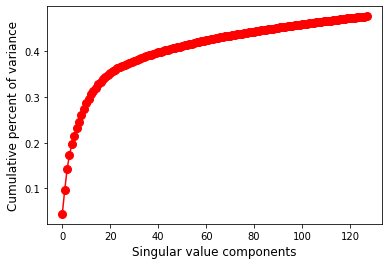

In [36]:
import matplotlib.pyplot as plt
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [37]:
latent_matrix_1_df = pd.DataFrame(latent_matrix,
                                  index=movies_meta['movieId'].tolist())

In [38]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
1,0.040733,0.000288,0.051061,0.002787,0.028925,0.011605,-0.090231,0.293034,-0.019821,0.198646,...,0.021040,0.016746,-0.029263,0.018391,-0.007460,-0.008678,0.019493,0.015955,-0.005917,0.009356
2,0.013167,0.000391,0.005223,0.001949,0.024602,0.013538,-0.019610,0.082290,-0.009335,0.016648,...,0.017463,-0.009605,-0.010681,0.002205,0.008143,0.011739,0.000689,-0.004963,0.020766,0.019891
3,0.025699,-0.000123,0.028008,-0.000756,0.000757,0.033766,0.006393,-0.000743,-0.004234,0.001167,...,0.021339,0.026002,-0.010369,0.017802,0.043932,-0.001545,-0.007649,0.026980,-0.011380,-0.004121
4,0.099710,-0.001300,0.028950,-0.003484,-0.008644,0.069895,0.014720,-0.002508,-0.008597,0.004705,...,0.002250,-0.002064,-0.002742,0.018183,0.067333,-0.015736,0.022762,0.005250,-0.060038,-0.019607
5,0.059480,-0.000102,0.083627,-0.001704,0.003635,-0.008453,-0.001699,0.017315,0.003003,0.003468,...,0.021544,0.029930,0.038174,0.045872,0.063606,0.028667,0.050038,0.056756,-0.082687,0.036413


In [39]:
latent_matrix_1_df.set_axis(['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)], axis='columns', inplace=True)
latent_matrix_1_df.columns

Index(['SVD_latent_0', 'SVD_latent_1', 'SVD_latent_2', 'SVD_latent_3',
       'SVD_latent_4', 'SVD_latent_5', 'SVD_latent_6', 'SVD_latent_7',
       'SVD_latent_8', 'SVD_latent_9',
       ...
       'SVD_latent_118', 'SVD_latent_119', 'SVD_latent_120', 'SVD_latent_121',
       'SVD_latent_122', 'SVD_latent_123', 'SVD_latent_124', 'SVD_latent_125',
       'SVD_latent_126', 'SVD_latent_127'],
      dtype='object', length=128)

In [40]:
latent_matrix_1_df['movieId'] = latent_matrix_1_df.index

In [41]:
latent_matrix_1_df.head()

,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,SVD_latent_6,SVD_latent_7,SVD_latent_8,SVD_latent_9,...,SVD_latent_119,SVD_latent_120,SVD_latent_121,SVD_latent_122,SVD_latent_123,SVD_latent_124,SVD_latent_125,SVD_latent_126,SVD_latent_127,movieId
1,0.040733,0.000288,0.051061,0.002787,0.028925,0.011605,-0.090231,0.293034,-0.019821,0.198646,...,0.016746,-0.029263,0.018391,-0.007460,-0.008678,0.019493,0.015955,-0.005917,0.009356,1
2,0.013167,0.000391,0.005223,0.001949,0.024602,0.013538,-0.019610,0.082290,-0.009335,0.016648,...,-0.009605,-0.010681,0.002205,0.008143,0.011739,0.000689,-0.004963,0.020766,0.019891,2
3,0.025699,-0.000123,0.028008,-0.000756,0.000757,0.033766,0.006393,-0.000743,-0.004234,0.001167,...,0.026002,-0.010369,0.017802,0.043932,-0.001545,-0.007649,0.026980,-0.011380,-0.004121,3
4,0.099710,-0.001300,0.028950,-0.003484,-0.008644,0.069895,0.014720,-0.002508,-0.008597,0.004705,...,-0.002064,-0.002742,0.018183,0.067333,-0.015736,0.022762,0.005250,-0.060038,-0.019607,4
5,0.059480,-0.000102,0.083627,-0.001704,0.003635,-0.008453,-0.001699,0.017315,0.003003,0.003468,...,0.029930,0.038174,0.045872,0.063606,0.028667,0.050038,0.056756,-0.082687,0.036413,5


In [42]:
movies = movies.merge(latent_matrix_1_df, on='movieId', how='left')

In [43]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Romance,Western,...,SVD_latent_118,SVD_latent_119,SVD_latent_120,SVD_latent_121,SVD_latent_122,SVD_latent_123,SVD_latent_124,SVD_latent_125,SVD_latent_126,SVD_latent_127
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,0.021040,0.016746,-0.029263,0.018391,-0.007460,-0.008678,0.019493,0.015955,-0.005917,0.009356
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1,0,0,...,0.017463,-0.009605,-0.010681,0.002205,0.008143,0.011739,0.000689,-0.004963,0.020766,0.019891
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0,1,0,...,0.021339,0.026002,-0.010369,0.017802,0.043932,-0.001545,-0.007649,0.026980,-0.011380,-0.004121
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0,1,0,...,0.002250,-0.002064,-0.002742,0.018183,0.067333,-0.015736,0.022762,0.005250,-0.060038,-0.019607
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,0.021544,0.029930,0.038174,0.045872,0.063606,0.028667,0.050038,0.056756,-0.082687,0.036413


In [44]:
numeric_features += ['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)]

#### SVD transform new movie

Note: SVD transform of a new movie (with corresponding TF-IDF features) can be done as follows:

In [45]:
latent_matrix = svd.transform(new_movie_feat)

In [46]:
latent_matrix.shape

(1, 128)

We save the SVD object for subsequent transform of new movies.

In [47]:
with open('./assets/svd.pkl', 'wb') as f:
    pickle.dump({"svd": svd}, f)

###  Popularity score

We compute the [popularity score](https://www.kaggle.com/rounakbanik/movie-recommender-systems) for each movie within the set of all movies as well as within each genre as follows:

```Weighted Rating (WR) = (v/(v+m).R)+(m/(v+m).C)```

where,

    v is the number of votes for the movie
    m is the minimum votes required to be listed in the chart
    R is the average rating of the movie
    C is the mean vote across the whole set


In [48]:
C = ratings['rating'].mean()
C

3.533854451353085

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [49]:
m = movies_num_ratings['userId_count'].quantile(0.95)
m

1503.3999999999942



Therefore, to qualify to be considered for the chart, a movie has to have at least 1503 votes on IMDB. We also see that the average rating for a movie on IMDB is 3.53 on a scale of 5. 2953 movies qualify to be on our chart.


In [50]:
qualified = movies[movies['userId_count'] >= m]

In [51]:
qualified.shape

(2953, 155)

In [52]:
def weighted_rating(x):
    v = x['userId_count']
    R = x['rating_mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [53]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

<ipython-input-53-a4cac61d7166>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['wr'] = qualified.apply(weighted_rating, axis=1)


In [54]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [55]:
qualified.head(5)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Romance,Western,...,SVD_latent_119,SVD_latent_120,SVD_latent_121,SVD_latent_122,SVD_latent_123,SVD_latent_124,SVD_latent_125,SVD_latent_126,SVD_latent_127,wr
314,318,"Shawshank Redemption, The (1994)",Crime Drama,81482.0,4.413576,1994.0,1994.0,0,0,0,...,0.010761,0.059749,-0.002112,0.021187,0.035553,-0.026131,0.012984,0.016027,0.007015,4.397639
840,858,"Godfather, The (1972)",Crime Drama,52498.0,4.324336,1972.0,1972.0,0,0,0,...,0.070553,0.020955,-0.082468,-0.021625,-0.007371,-0.026340,0.015124,-0.003139,0.046352,4.302329
49,50,"Usual Suspects, The (1995)",Crime Mystery Thriller,55366.0,4.284353,1995.0,1995.0,0,0,0,...,-0.020606,0.106848,-0.022363,0.059835,0.001038,-0.044900,0.015275,0.041978,0.035593,4.264513
1190,1221,"Godfather: Part II, The (1974)",Crime Drama,34188.0,4.261759,1974.0,1974.0,0,0,0,...,0.073246,0.032179,-0.078985,-0.013315,-0.011281,-0.031998,0.011805,-0.024160,0.049677,4.231098
522,527,Schindler's List (1993),Drama War,60411.0,4.247579,1993.0,1993.0,0,0,0,...,-0.022783,-0.007273,-0.012655,-0.011802,0.018889,0.001523,-0.024955,0.002229,0.010925,4.230248


In [56]:
cat_features += [g for g in genres]

#### Popularity score per genre

In [57]:
def build_chart(genre, percentile=0.85):
    df = movies[movies[genre] == 1] #filter out genre
    
    C = ratings['rating'].mean()
    m = movies_num_ratings['userId_count'].quantile(percentile)
    
    qualified = df[df['userId_count'] >= m]
    qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
    
    qualified = qualified.sort_values('%s_wr'%genre, ascending=False).head(250)
    qualified.reset_index(inplace=True, drop=True)
    qualified['%s_rank'%genre] = qualified.index
    
    return qualified

In [58]:
for genre in tqdm(genres):
     chart = build_chart(genre)
     movies = movies.merge(chart[["movieId", "%s_wr"%genre, "%s_rank"%genre]], on='movieId', how='left')    

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-57-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
  5%|▌         | 1/20 [00:00<00:07,  2.62it/s]<ipython-input-57-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
 10%|█         | 2/20 [00:00<00:07,  2.34it/s]<ipython-input-57-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be 

In [59]:
movies.fillna(0, inplace=True)

In [60]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Romance,Western,...,Animation_wr,Animation_rank,Film-Noir_wr,Film-Noir_rank,(no genres listed)_wr,(no genres listed)_rank,Documentary_wr,Documentary_rank,Thriller_wr,Thriller_rank
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,3.884509,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
movies.shape

(62423, 195)

In [62]:
numeric_features += ["%s_wr"%g for g in genres]
numeric_features += ["%s_rank"%g for g in genres]

In [63]:
with open('./assets/features.pkl', 'wb') as f:
    pickle.dump({"numeric_features": numeric_features, 'cat_features': cat_features }, f)


In [64]:
print(len(cat_features))
print(len(numeric_features))

21
171


### Merging with IMDB ID

In [65]:
movies = movies.merge(links, on='movieId', how='left')

In [66]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Romance,Western,...,Film-Noir_wr,Film-Noir_rank,(no genres listed)_wr,(no genres listed)_rank,Documentary_wr,Documentary_rank,Thriller_wr,Thriller_rank,imdbId,tmdbId
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0114709,862
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0113497,8844
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0113228,15602
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0114885,31357
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0113041,11862


In [77]:
movies.to_parquet(MOVIE_LENS_DATA_PATH+"movies_features.parquet", index=False)

In [68]:
movies.shape

(62423, 197)

# Divide into train and test

We use all examples for training, except the last-watched movies for testing.

In [69]:
ratings.tail()

,userId,movieId,rating,timestamp
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434
25000094,162541,63876,5.0,1240952515


## Forming binary dataset

To train a DLRM network, we will need binary labels. Herein we will employ a simple strategy. The ratings are on a scale between 1-5. We want to predict a binary target with 1 are all ratings >=4 and 0 are all ratings <=3.

In [70]:
ratings['label'] = 0
ratings.loc[ratings['rating']>3,'label'] = 1
ratings.loc[ratings['rating']<=3,'label'] = 0


In [71]:
MIN_RATINGS = 20
USER_COLUMN = 'userId'
ITEM_COLUMN = 'movieId'

grouped = ratings.groupby(USER_COLUMN)

In [72]:
df = ratings

# Need to sort before popping to get last item
df.sort_values(by='timestamp', inplace=True)

# clean up data
del df['rating'], df['timestamp']
df = df.drop_duplicates() # assuming it keeps order

In [73]:
movies[cat_features] = movies[cat_features].astype('int32')
movies[numeric_features] = movies[numeric_features].astype('float32')

# now we have filtered and sorted by time data, we can split test data out
grouped_sorted = df.groupby(USER_COLUMN, group_keys=False)
test_data = grouped_sorted.tail(1).sort_values(by=USER_COLUMN)
# need to pop for each group
train_data = grouped_sorted.apply(lambda x: x.iloc[:-1])

In [74]:
#train_data = train_data.merge(movies, on='movieId')
#train_data.head()

In [75]:
#test_data = test_data.merge(movies, on='movieId')
#test_data.head()

In [76]:
BASE_DIR = MOVIE_LENS_DATA_PATH + 'NVTab_preprocessing/'
!mkdir $BASE_DIR

train_data.to_parquet(BASE_DIR + "train.parquet")
train_data.to_parquet(BASE_DIR + "test.parquet")

mkdir: cannot create directory ‘./data/ml-25m/NVTab_preprocessing/’: File exists


## Preprocessing with NVTabular

In [79]:
# External dependencies
import os
import gc
from os import path

import numpy as np
import cudf
import nvtabular as nvt

In [80]:
CATEGORICAL_COLUMNS = cat_features
NUMERICAL_COLUMNS = numeric_features
LABEL_COLUMNS = ["label"]

In [78]:
df_external = cudf.read_parquet(MOVIE_LENS_DATA_PATH+"movies_features.parquet")

In [81]:
# Use JoinExternal to define a NVTabular workflow
joined_cat = nvt.ColumnGroup(['movieId', 'userId']) >> nvt.ops.JoinExternal(
    df_external,
    on=['movieId'],
    on_ext=['movieId'],
    how='left',
    columns_ext=cat_features,
    kind_ext='cudf',
    cache='device'
)  >> nvt.ops.Categorify()

In [86]:
# Use JoinExternal to define a NVTabular workflow
joined_num = nvt.ColumnGroup(['movieId']) >> nvt.ops.JoinExternal(
    df_external,
    on=['movieId'],
    on_ext=['movieId'],
    how='left',
    columns_ext=numeric_features,
    kind_ext='cudf',
    cache='device'
) >> nvt.ops.Normalize()

In [87]:
output = joined_cat + joined_num + LABEL_COLUMNS
(output).graph

ValueError: duplicate column names found: {'movieId'}

In [84]:
workflow = nvt.Workflow(output)

NameError: name 'output' is not defined

In [ ]:
!ls -l $BASE_DIR

In [ ]:
train_dataset = nvt.Dataset(BASE_DIR + "train.parquet", part_size="1500MB")
valid_dataset = nvt.Dataset(BASE_DIR + "test.parquet", part_size="500MB")